In [23]:
# Cell 1 — setup
import os, warnings, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import ISICDataset  # your class

# paths
IMAGE_DIR = r"F:/datasets/ISIC2024/train-image/image"
METADATA_FILE = r"F:/datasets/ISIC2024/train-metadata-updated.csv"

# load metadata
df = pd.read_csv(METADATA_FILE)
display(df.head(8))
print("Rows:", len(df))
print("Columns:", list(df.columns))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_6442165,0,IP_5426188,65.0,male,posterior torso,4.36,TBP tile: close-up,3D: XP,21.214290,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.998920
1,ISIC_5643240,0,IP_1117889,55.0,female,lower extremity,5.95,TBP tile: close-up,3D: XP,16.883219,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.963148
2,ISIC_4550094,0,IP_7834081,45.0,male,upper extremity,3.81,TBP tile: close-up,3D: white,21.015530,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.431560
3,ISIC_7555689,0,IP_7346729,65.0,male,lower extremity,3.49,TBP tile: close-up,3D: XP,20.895130,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
4,ISIC_8401419,0,IP_0541183,75.0,female,posterior torso,4.28,TBP tile: close-up,3D: white,20.607570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.495405
5,ISIC_6433904,0,IP_0528395,65.0,male,lower extremity,3.99,TBP tile: close-up,3D: XP,21.145342,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
6,ISIC_9890424,0,IP_5811816,85.0,male,posterior torso,4.85,TBP tile: close-up,3D: XP,16.108490,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.996860
7,ISIC_5037739,0,IP_8685501,75.0,female,posterior torso,3.12,TBP tile: close-up,3D: white,19.788910,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.996470


Rows: 5293
Columns: ['isic_id', 'target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']


In [24]:
# Cell 2 — missingness + dtypes
display(df.dtypes.to_frame("dtype").T)
missing = (df.isna().mean()*100).sort_values(ascending=False)
display(missing.head(20).rename("missing_%").to_frame())

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
dtype,object,int64,object,float64,object,object,float64,object,object,float64,...,object,object,object,object,object,object,float64,object,float64,float64


,missing_%
iddx_5,100.000000
mel_mitotic_index,98.998677
mel_thick_mm,98.828642
iddx_4,95.409031
iddx_2,92.537313
iddx_3,92.537313
lesion_id,87.436237
sex,3.117325
anatom_site_general,1.209144
age_approx,0.793501


,class,count,frac
0,0,4907,0.927073
1,1,386,0.072927


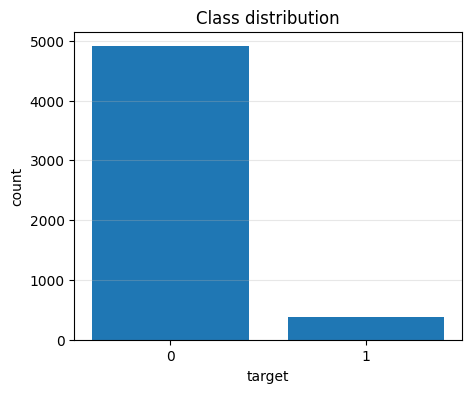

Positive rate (target==1): 7.29 %


In [25]:
# Cell 3 — class balance
assert "target" in df.columns, "Expected 'target' column not found."

vc = df["target"].value_counts().sort_index()
balance = pd.DataFrame({"class": vc.index, "count": vc.values, "frac": vc.values/len(df)})
display(balance)

plt.figure(figsize=(5,4))
plt.bar(vc.index.astype(str), vc.values)
plt.title("Class distribution")
plt.xlabel("target"); plt.ylabel("count"); plt.grid(True, axis="y", alpha=0.3)
plt.show()

print("Positive rate (target==1):", round((df['target']==1).mean()*100, 2), "%")

,count
anatom_site_general,
posterior torso,1595
lower extremity,1273
anterior torso,1208
upper extremity,904
head/neck,249
NA,64


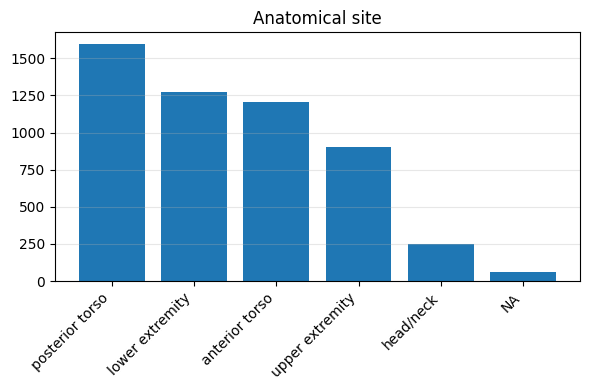

,count
sex,
male,3544
female,1584
NA,165


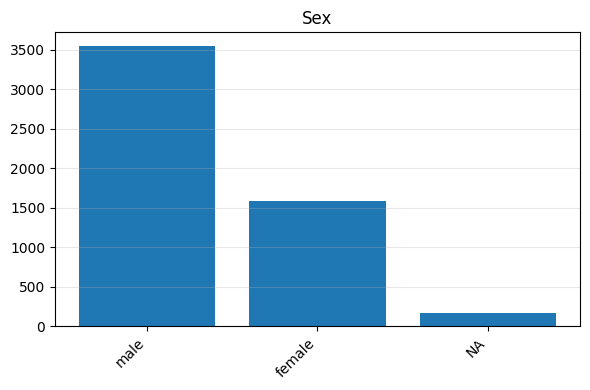

count    5251.000000
mean       58.549800
std        13.520226
min        15.000000
25%        50.000000
50%        60.000000
75%        70.000000
max        85.000000
Name: age_approx, dtype: float64

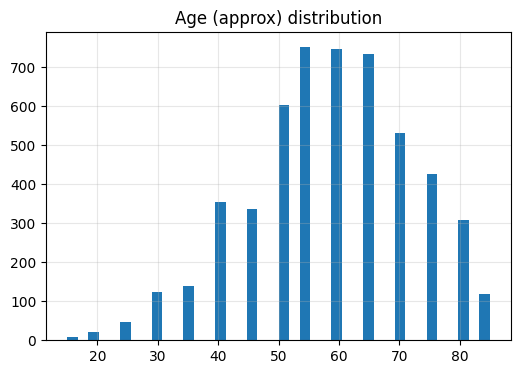

In [26]:
# Cell 4 — optional quick views
def show_bar(col, title):
    if col in df.columns:
        vc = df[col].fillna("NA").value_counts()
        display(vc.to_frame("count"))
        plt.figure(figsize=(6,4))
        plt.bar(vc.index.astype(str), vc.values)
        plt.title(title); plt.xticks(rotation=45, ha="right"); plt.grid(True, axis="y", alpha=0.3)
        plt.tight_layout(); plt.show()

def show_hist(col, title, bins=40):
    if col in df.columns:
        vals = pd.to_numeric(df[col], errors="coerce").dropna()
        display(vals.describe())
        plt.figure(figsize=(6,4))
        plt.hist(vals, bins=bins)
        plt.title(title); plt.grid(True, alpha=0.3)
        plt.show()

show_bar("anatom_site_general", "Anatomical site")
show_bar("sex", "Sex")
show_hist("age_approx", "Age (approx) distribution")

In [27]:
# Cell 5 — dataset & one batch
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = ISICDataset(df, IMAGE_DIR, transform=transform, load_images_to_ram=False)
loader  = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

images, labels, ids = next(iter(loader))
print("Batch images:", images.shape, "| labels:", labels.shape)

Batch images: torch.Size([16, 3, 224, 224]) | labels: torch.Size([16])


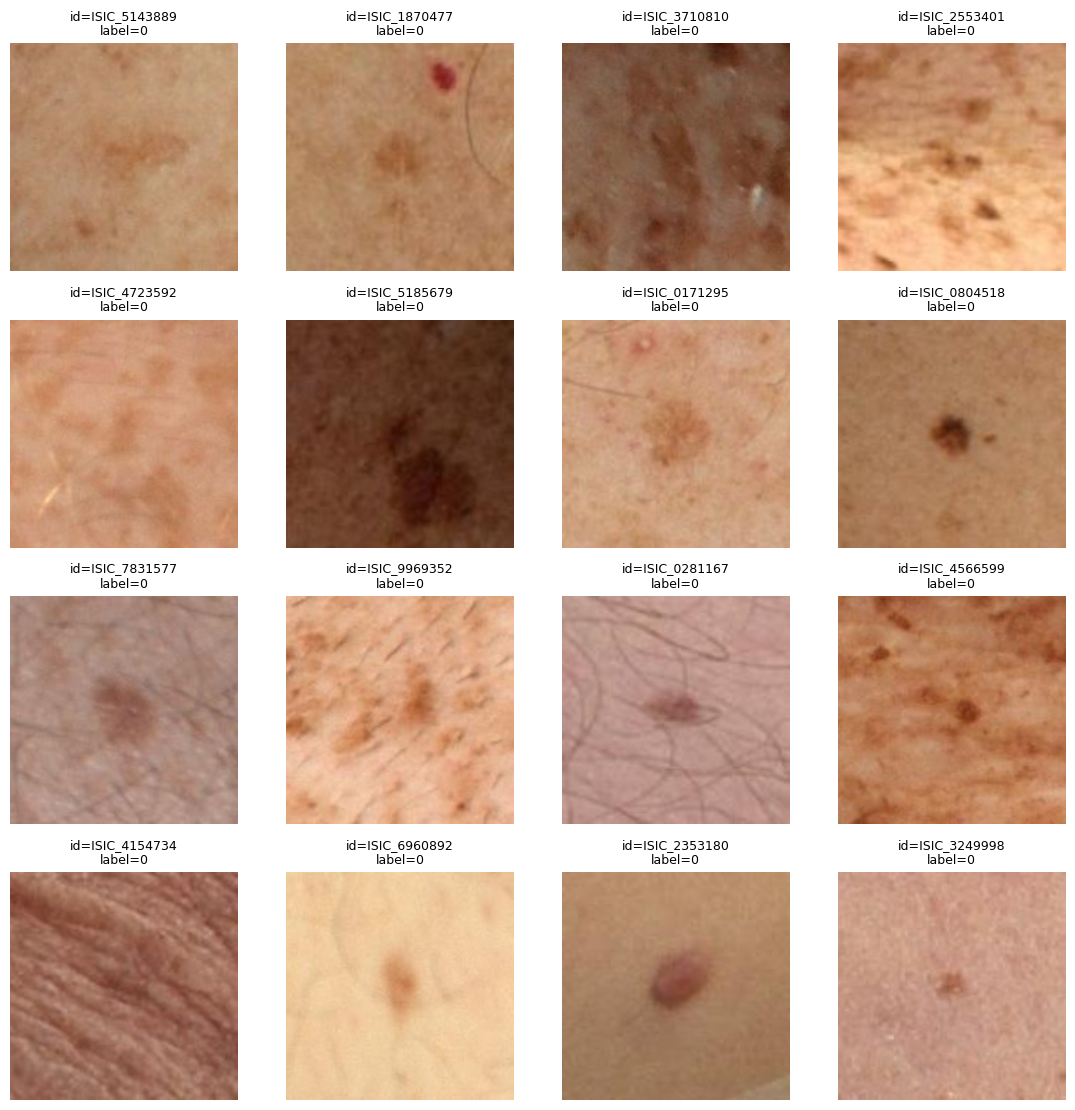

In [28]:
# Cell 6 — sample grid
def show_grid(images, labels, ids, n=16):
    n = min(n, images.size(0))
    cols = int(math.sqrt(n)); rows = int(math.ceil(n/cols))
    plt.figure(figsize=(2.8*cols, 2.8*rows))
    for i in range(n):
        img = images[i].permute(1,2,0).cpu().numpy()
        img = np.clip(img, 0, 1)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"id={ids[i]}\nlabel={int(labels[i])}", fontsize=9)
    plt.tight_layout(); plt.show()

show_grid(images, labels, ids, n=16)